# Задание:
В этом задании вам предлагается проанализировать результаты A/B-теста игры Cookie Cats. Результаты A/B-теста хранятся в таблице cookie_cats.ab_results.
Cookie Cats — это мобильная игра-головоломка, разработанная компанией Tactile Entertainment. Это классическая игра в стиле «соедини три», где игрок должен соединить плитки одного цвета, чтобы очистить поле и выиграть уровень. Основным сеттингом игры являются кошки и необходимость их накормить лакомствами. 

По мере прохождения игры игроки сталкиваются с барьерами, которые заставляют их ждать некоторое время для продолжения или совершить покупку внутри приложения.
Подробнее ознакомиться с игрой вы можете либо посмотрев видео с геймплеем игры, либо поиграв в нее самостоятельно! iOS, Android

У нас есть данные по новым игрокам за некоторый период, которые устанавливали игру и получали одну из версий - либо первый барьер стоял на 30 уровне, либо на 40ом.
Вам, как аналитику, необходимо, во-первых, провести разведочный анализ (EDA), а во-вторых, подвести итоги A/B-теста. После чего необходимо написать выводы для гейм-дизайнера (заказчика), который придумал это изменение. И также сформировать гипотезу, почему был получен тот результат, который был получен. 

Для разведочного анализа вам необходимо каждый раз данные формировать с помощью SQL-скрипта, а затем, используя выгруженные данные, построить необходимые таблицы и графики.

Для подведения итогов A/B-теста вам необходимо оценить следующую гипотезу: 
**Если первый барьер перенести с 30 на 40 уровень, то вырастет retention игроков, а также квантили количества пройденных игроками уровней.**

Для ее анализа вам необходимо оценить следующие метрики с использованием bootstrap:
- retention 1-day
- retention 7-day
- медиана sum_gamerounds
- среднее sum_gamerounds
- 75% квантиль sum_gamerounds
- 95% квантиль sum_gamerounds
Уровень значимости - 5%. 
Bootstrap необходимо обязательно реализовать в виде UDF в Postgres. В схеме cookiecats у вас есть права на создание функций. Функцию необходимо назвать как bootstrap<фамилияио>. Пример: bootstrap_ivanov_i_i

В конце ноутбука ожидаются выводы по результатам A/B-теста с рекомендацией о том, что нужно делать заказчику далее.

### Подключение к базе данных

Так как хранить параметры учётной записи в коде небезопасно, создадим хранилище.

Я оставил код для создания хранилища, чтобы его можно было проверить. Если Вы не захотите создавать хранилище, можно взять значения, которые я в него сохранял, и внести в переменные user, password, host, port

In [ ]:
!pip install keyring -q

In [ ]:
import keyring

# Установка секретов
keyring.set_password("sql_course_database", "user", "student")
keyring.set_password("sql_course_database", "password", "6ecf4d61")
keyring.set_password("sql_course_database", "host", "92.63.70.133")
keyring.set_password("sql_course_database", "port", "5432")

In [38]:
import keyring

# Получение секретов
user = keyring.get_password("sql_course_database", "user")
password = keyring.get_password("sql_course_database", "password")
host = keyring.get_password("sql_course_database", "host")
port = keyring.get_password("sql_course_database", "port")

## Разведочный анализ данных

In [46]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keyring

conn_params = {
    'dbname': "project",
    'user': keyring.get_password("sql_course_database", "user"),
    'password': keyring.get_password("sql_course_database", "password"),
    'host': keyring.get_password("sql_course_database", "host"),
    'port': keyring.get_password("sql_course_database", "port")
}

def execute_query(query, params=None):
    with psycopg2.connect(**conn_params) as conn:
        with conn.cursor() as cursor:
            cursor.execute(query, params)
            if cursor.description:
                columns = [desc[0] for desc in cursor.description]
                data = cursor.fetchall()
                return pd.DataFrame(data, columns=columns)
            else:
                conn.commit()
                return None

# Общая информация о данных
query_1 = """
SELECT 
    COUNT(*) AS row_count
    , (SELECT COUNT(*) 
     FROM (SELECT DISTINCT userid, version, sum_gamerounds, retention_1, retention_7 
           FROM cookie_cats.ab_results) AS uniq_rows) AS uniq_row_count
    , COUNT(DISTINCT userid) AS uniq_userid_count
    , COUNT(*) FILTER (WHERE userid IS NOT NULL) AS non_null_userid
    , COUNT(*) FILTER (WHERE version IS NOT NULL) AS non_null_version
    , COUNT(*) FILTER (WHERE sum_gamerounds IS NOT NULL) AS non_null_sum_gamerounds
    , COUNT(*) FILTER (WHERE retention_1 IS NOT NULL) AS non_null_retention_1
    , COUNT(*) FILTER (WHERE retention_7 IS NOT NULL) AS non_null_retention_7
FROM cookie_cats.ab_results
"""
df_1 = execute_query(query_1)
print("Общая информация о данных:")
print(df_1)

# Описательная статистика
query_2 = """
SELECT 
    MIN(sum_gamerounds) AS min_rounds
    , MAX(sum_gamerounds) AS max_rounds
    , AVG(sum_gamerounds) AS avg_rounds
    , PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY sum_gamerounds) AS median_rounds
FROM cookie_cats.ab_results;
"""
df_2 = execute_query(query_2)
print("\nОписательная статистика для sum_gamerounds:")
print(df_2)

query_3 = """
SELECT 
    version
    , COUNT(*) AS count_all
    , COUNT(*) FILTER (WHERE sum_gamerounds >= 30) count_more_30
    , COUNT(*) FILTER (WHERE sum_gamerounds >= 40) count_more_40
FROM cookie_cats.ab_results
GROUP BY version
"""
df_3 = execute_query(query_3)
print("\nРаспределение по группам (version):")
print(df_3)

# Анализ групп (version)
query_4 = """
SELECT 
    version
    , AVG(sum_gamerounds) AS avg_rounds
    , PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY sum_gamerounds) AS median_rounds
    , AVG(retention_1::int) AS retention_1_rate
    , AVG(retention_7::int) AS retention_7_rate
FROM cookie_cats.ab_results
GROUP BY version;
"""
df_4 = execute_query(query_4)
print("\nСравнение средних значений между группами:")
print(df_4)

# Анализ игровых раундов (sum_gamerounds)
query_5 = """
SELECT sum_gamerounds, COUNT(*) AS count
FROM cookie_cats.ab_results
GROUP BY sum_gamerounds
ORDER BY sum_gamerounds;
"""
df_5 = execute_query(query_5)
print("\nРаспределение количества игровых раундов:")
print(df_5)

query_6 = """
SELECT *
FROM cookie_cats.ab_results
WHERE 1=1
    AND sum_gamerounds > 1000
"""
df_6 = execute_query(query_6)
print("\nИгроки с более чем 1000 раундов (выбросы):")
print(df_6)

# Анализ удержания (retention_1 и retention_7)
query_7 = """
SELECT 
    AVG(retention_1::int) * 100 AS retention_1_rate
    , AVG(retention_7::int) * 100 AS retention_7_rate
FROM cookie_cats.ab_results
"""
df_7 = execute_query(query_7)
print("\nПроцент удержания игроков:")
print(df_7)

query_8 = """
SELECT 
    version
    , AVG(retention_1::int) * 100 AS retention_1_rate
    , AVG(retention_7::int) * 100 AS retention_7_rate
FROM cookie_cats.ab_results
GROUP BY version;
"""
df_8 = execute_query(query_8)
print("\nСравнение удержания между группами:")
print(df_8)

Общая информация о данных:
   row_count  uniq_row_count  uniq_userid_count  non_null_userid  \
0      90189           90189              90189            90189   

   non_null_version  non_null_sum_gamerounds  non_null_retention_1  \
0             90189                    90189                 90189   

   non_null_retention_7  
0                 90189  

Описательная статистика для sum_gamerounds:
   min_rounds  max_rounds           avg_rounds  median_rounds
0           0       49854  51.8724567297564004           16.0

Распределение по группам (version):
   version  count_all  count_more_30  count_more_40
0  gate_30      44700          16656          13566
1  gate_40      45489          16613          13827

Сравнение средних значений между группами:
   version           avg_rounds  median_rounds        retention_1_rate  \
0  gate_30  52.4562639821029083           17.0  0.44818791946308724832   
1  gate_40  51.2987755281496626           16.0  0.44228274967574578470   

         reten

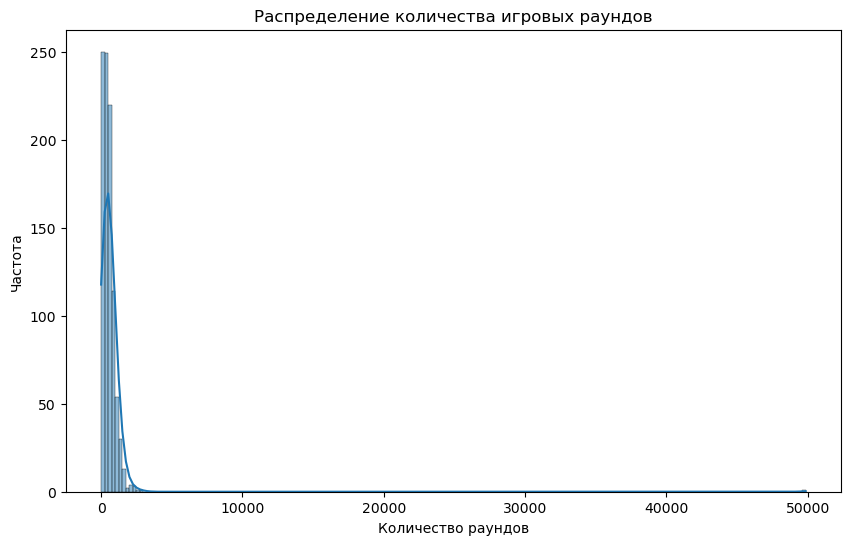

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(df_5['sum_gamerounds'], bins=200, kde=True)
plt.title('Распределение количества игровых раундов')
plt.xlabel('Количество раундов')
plt.ylabel('Частота')
plt.show()

In [41]:
df_4

,version,avg_rounds,median_rounds,retention_1_rate,retention_7_rate
0,gate_30,52.4562639821029083,17.0,0.44818791946308724832,0.19020134228187919463
1,gate_40,51.2987755281496626,16.0,0.44228274967574578470,0.18200004396667326167


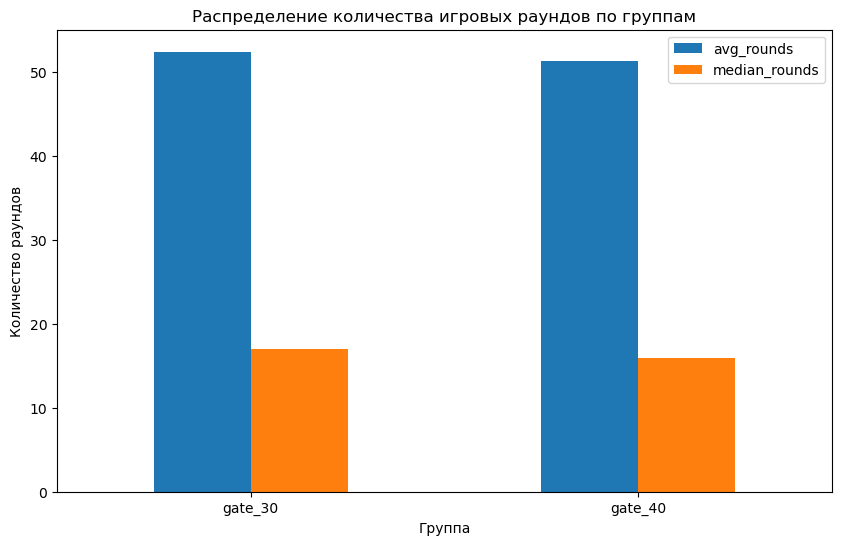

In [42]:
df_4['avg_rounds'] = df_4['avg_rounds'].astype(float)
df_4['median_rounds'] = df_4['median_rounds'].astype(float)

df_4.plot(x='version', y=['avg_rounds', 'median_rounds'], kind='bar', figsize=(10, 6))
plt.title('Распределение количества игровых раундов по группам')
plt.xlabel('Группа')
plt.ylabel('Количество раундов')
plt.xticks(rotation=0)
plt.show();

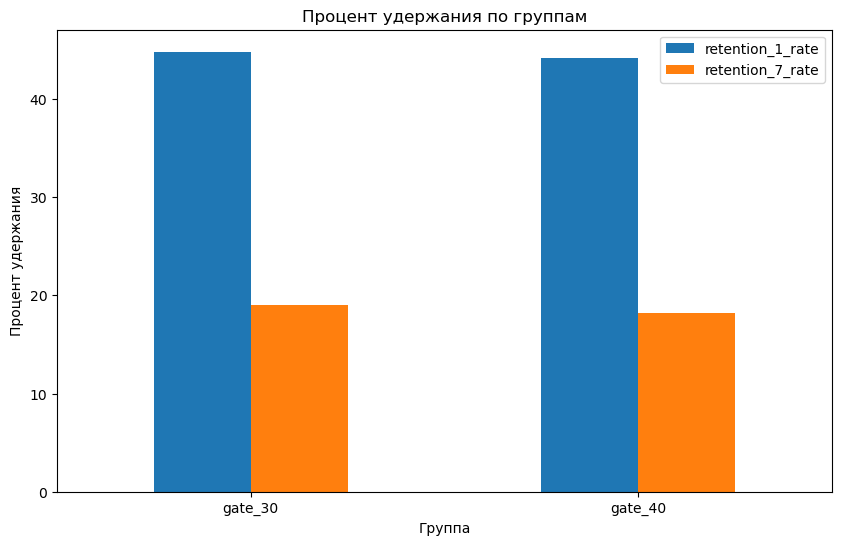

In [43]:
df_8['retention_1_rate'] = df_8['retention_1_rate'].astype(float)
df_8['retention_7_rate'] = df_8['retention_7_rate'].astype(float)

df_8.plot(x='version', y=['retention_1_rate', 'retention_7_rate'], kind='bar', figsize=(10, 6))
plt.title('Процент удержания по группам')
plt.xlabel('Группа')
plt.ylabel('Процент удержания')
plt.xticks(rotation=0)
plt.show()

### Выводы по EDA
1) В таблице нет пропусков, дубликатов.
2) Uруппы примерно равны между собой? количество видевших баннер примерно равно в двух группах.
3) Минимальное количество сыгранных раундов - 0, максимальное - 49854, среднее 52, медианное 16. Количество сыгранных раундов подвержено выбросам и быстро падает. Основное количество игроков сыграли менее 100 раундов. Более 1000 раундов имеют всего 116 игроков.
4) Распределение количества сыгранных раундов и процент удержания по группам различается незначительно

## Анализ результатов A/B-тестирования

In [44]:
query_ab = """
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(retention_1::int) from cookie_cats.ab_results where version = 'gate_30'),
    (select array_agg(retention_1::int) from cookie_cats.ab_results where version = 'gate_40'),
    'retention_1'
)
union all
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(retention_7::int) from cookie_cats.ab_results where version = 'gate_30'),
    (select array_agg(retention_7::int) from cookie_cats.ab_results where version = 'gate_40'),
    'retention_7'
)
union all
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_30'),
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_40'),
    'median_gamerounds'
)
union all
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_30'),
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_40'),
    'mean_gamerounds'
)
union all
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_30'),
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_40'),
    '75_quantile_gamerounds'
)
union all
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_30'),
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_40'),
    '95_quantile_gamerounds'
)
"""
df_ab = execute_query(query_ab)
print("Сравнение метрик в контрольной и тестовой группах:")
df_ab

Сравнение метрик в контрольной и тестовой группах:


,metric_name,group_a_lower,group_a_upper,group_b_lower,group_b_upper
0,retention_1,0.400391,0.492170,0.398678,0.486784
1,retention_7,0.154362,0.225951,0.147577,0.215859
2,median_gamerounds,14.000000,20.000000,13.000000,19.500000
3,mean_gamerounds,42.325559,61.929139,42.048238,60.678304
4,75_quantile_gamerounds,40.987500,61.500000,42.000000,64.256250
5,95_quantile_gamerounds,167.497500,280.410000,170.098750,278.717500


Так как мы ожидаем эффект из-за просмотра баннера, имеет смысл посмотреть конкретно на тех игроков, которые его увидели, а не на всю группу. Так как в первой группе игроки видели баннер после 30 уровня, а во второй после 40, то было решено смотреть на тех, кто сыграл более 40 уровней (так можно будет сравнивать между собой медианное и среднее количество сыгранных уровней, хотя мы и упустим тех, кто видел баннер на 30 уровне но не дошёл до 40).

In [47]:
query_ab = """
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(retention_1::int) from cookie_cats.ab_results where version = 'gate_30' and sum_gamerounds >= 40),
    (select array_agg(retention_1::int) from cookie_cats.ab_results where version = 'gate_40' and sum_gamerounds >= 40),
    'retention_1'
)
union all
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(retention_7::int) from cookie_cats.ab_results where version = 'gate_30' and sum_gamerounds >= 40),
    (select array_agg(retention_7::int) from cookie_cats.ab_results where version = 'gate_40' and sum_gamerounds >= 40),
    'retention_7'
)
union all
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_30' and sum_gamerounds >= 40),
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_40' and sum_gamerounds >= 40),
    'median_gamerounds'
)
union all
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_30' and sum_gamerounds >= 40),
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_40' and sum_gamerounds >= 40),
    'mean_gamerounds'
)
union all
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_30' and sum_gamerounds >= 40),
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_40' and sum_gamerounds >= 40),
    '75_quantile_gamerounds'
)
union all
select * from cookiecats.bootstrap_fomin_p_a(
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_30' and sum_gamerounds >= 40),
    (select array_agg(sum_gamerounds) from cookie_cats.ab_results where version = 'gate_40' and sum_gamerounds >= 40),
    '95_quantile_gamerounds'
)
"""
df_ab = execute_query(query_ab)
print("Сравнение метрик в контрольной и тестовой группах только по тем, у кого наиграно более 40 уровней:")
df_ab

Сравнение метрик в контрольной и тестовой группах только по тем, у кого наиграно более 40 уровней:


,metric_name,group_a_lower,group_a_upper,group_b_lower,group_b_upper
0,retention_1,0.770370,0.896296,0.768116,0.884058
1,retention_7,0.414815,0.585370,0.405797,0.565399
2,median_gamerounds,76.000000,109.000000,78.500000,108.000000
3,mean_gamerounds,119.788148,169.534074,118.967572,171.036775
4,75_quantile_gamerounds,136.487500,205.000000,135.750000,201.006250
5,95_quantile_gamerounds,303.397500,548.310000,296.536250,533.801250


### Выводы по A/B
1) Гипотезы по всем метрикам не подтвердились (доверительные интервалы пересекаются)
2) Гипотеза, почему так получилось - прошло недостаточно времени с начала A/B-теста, и большинство пользователей не упёрлись в установленные барьеры (медианное значение сыгранных раундов в обеих группах всего 16 уровней.
3) Рекомендации для заказчика - следует протестировать возможность перенести барьер на более ранние уровни (например, 15), так как половина игроков за 2 недели доходит проходит только 15 уровней.